In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from keras.utils.np_utils import to_categorical

%matplotlib inline
from PIL import Image
import os, glob, random
import random, math

In [3]:
# npy, npzファイル：Numpy配列 ndarray を保存するバイナリファイル
outfile="resistors_org_data.npz"#保存ファイル名
max_photo=10
photo_size=80
x=[]#画像データ
y=[]#ラベルデータ
#各抵抗値
categories = ["10","22","47",
              "100","220","470",
              "1k","2.2k","4.7k",
              "10k","22k","47k",
              "100k","220k","470k",
              "1M","2.2M"]

#path以下の画像を読み込む
def glob_files(path,label):
    files=glob.glob(path+"/*.JPG") #フォルダ内の画像ファイル名をリストで返す
    random.shuffle(files) #フォルダごとに画像をシャッフル
    #各ファイルを処理
    num=0
    for f in files:
        if num >=max_photo:break
        num+=1
        #画像ファイルを読む
        img=cv2.imread(f)
        img=cv2.resize(img, (photo_size,photo_size ))
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img=np.asarray(img)
        x.append(img)
        y.append(label)
        
    print(num)
    
def main():
    for cat, label in zip(categories, range(len(categories))):
        #各画像のフォルダーを読む(./は現在のフォルダ)
        glob_files("./resistors/" + cat, label)
    
    #x(学習データ),y(ラベル)の対応は維持したままシャッフル
    for l in [x, y]:
        np.random.seed(1)
        np.random.shuffle(l) 
    
    #ファイルへ保存
    np.savez(outfile,x=x,y=y)#xとyがnumpyのリストとして与えられる
    print("保存しました："+outfile,len(x))
    
# コマンドラインでファイルを指定して起動された場合は True で実行される
# importでインポートされた場合は False で実行されない
if __name__=="__main__":
    main()

10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
10
保存しました：resistors_org_data.npz 170


1


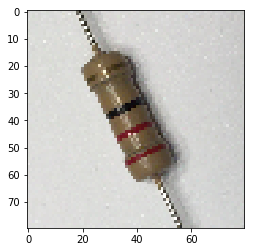

In [5]:
plt.imshow(x[2])
print(y[2])

In [1]:
x_list.shape

NameError: name 'x_list' is not defined

In [7]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

# ImageDataGeneratorクラスのオブジェクト生成
datagen = ImageDataGenerator(
        rotation_range=45,
        vertical_flip=True,
        horizontal_flip=True)

def images_gen(x_list,y_list):
    x_list_add=[]
    y_list_add=[]
    for x ,y in zip(x_list,y_list):#xは(3, 150, 150)で受け取る
        x = x.reshape((1,) + x.shape)  #(1, 3, 150, 150)に変換する

        batch_list=[]
        i = 0
        
        # flowメソッド：numpyデータとラベルの配列を受け取り、拡張/正規化したデータのバッチを生成
        for batch in datagen.flow(x, batch_size=1):
            batch=batch.astype(np.uint8)#データ型を揃える
            batch=batch.reshape((photo_size, photo_size, 3))
            x_list_add.append(batch)
            y_list_add.append(y)
            i += 1
            if i > 9:#１枚から10枚作る(計1700=10*17*10)
                break             
    x_np_add=np.array(x_list_add)
    y_np_add=np.array(y_list_add)

    #x(学習データ),y(ラベル)の対応は維持したままシャッフル
    for l in [x_np_add, y_np_add]:
        np.random.seed(1)
        np.random.shuffle(l) 

    return x_np_add,y_np_add

In [19]:
#入力と出力を指定
im_rows=photo_size
im_cols=photo_size
im_color=3
in_shape=(im_rows,im_cols,im_color)
nb_classes=17

In [9]:
#写真データを読み込み
photos=np.load("./resistors_org_data.npz")
x=photos["x"]
y=photos["y"]

In [10]:
#読み込んだデータを三次元配列に変換
x=x.reshape(-1,im_rows,im_cols,im_color)

In [11]:
print(x.shape)
print(y.shape)

(170, 80, 80, 3)
(170,)


In [12]:
#水増し
x_add,y_add=images_gen(x,y)

outfile_add="resistors_add1700_data.npz"#保存ファイル名

#ファイルへ保存
np.savez(outfile_add,x=x_add,y=y_add)
print("保存しました："+outfile_add,len(x_add))

保存しました：resistors_add1700_data.npz 1700


15


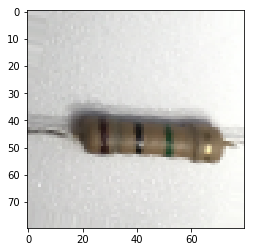

In [25]:
n = 1300
plt.imshow(x_add[n])
print(y_add[n])

In [21]:
import keras
from keras.models import  Sequential
from keras.layers import Dense,Dropout,Flatten
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import  RMSprop

#cnnのモデルを定義する

def def_model(in_shape,nb_classes):
    model=Sequential()
    model.add(Conv2D(32,
                    kernel_size=(3,3),
                    activation="relu",
                    input_shape=in_shape))
    model.add(Conv2D(32,(3,3),activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64,(3,3),activation="relu"))
    model.add(Conv2D(64,(3,3),activation="relu",name="relu_conv2"))
   #最後の畳み込み層の名称を後ほど使うので定義しておく。
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512,activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes,activation="softmax"))
    
    return model

#コンパイル済みのcnnのモデルを返す

def get_model(in_shape,nb_classes):
    model=def_model(in_shape,nb_classes)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=RMSprop(),
        metrics=["accuracy"])
    return model

C:\Users\toshi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Train on 1360 samples, validate on 340 samples
Epoch 1/20
1360/1360 [==============================] - 28s 21ms/step - loss: 3.2028 - accuracy: 0.0596 - val_loss: 2.8340 - val_accuracy: 0.0471
Epoch 2/20
1360/1360 [==============================] - 27s 20ms/step - loss: 2.8417 - accuracy: 0.0647 - val_loss: 2.8344 - val_accuracy: 0.0471
Epoch 3/20
1360/1360 [==============================] - 27s 20ms/step - loss: 2.8402 - accuracy: 0.0463 - val_loss: 2.8327 - val_accuracy: 0.0471
Epoch 4/20
1360/1360 [==============================] - 27s 19ms/step - loss: 2.8407 - accuracy: 0.0551 - val_loss: 2.8353 - val_accuracy: 0.0471
Epoch 5/20
1360/1360 [==============================] - 26s 19ms/step - loss: 2.8374 - accuracy: 0.0610 - val_loss: 2.8331 - val_accuracy: 0.0794
Epoch 6/20
1360/1360 [==============================] - 26s 19ms/step - loss: 2.7861 - accuracy: 0.0941 - val_loss: 4.2497 - val_accuracy: 0.0559
Epoch 7/20
1360/1360 [==============================] - 29s 22ms/step - loss:

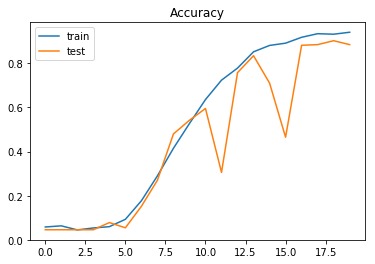

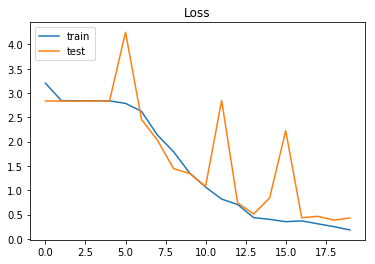

In [22]:
from sklearn.model_selection import train_test_split

#写真データを読み込み
photos=np.load("./resistors_add1700_data.npz")
x=photos["x"]
y=photos["y"]

#読み込んだデータを三次元配列に変換
x=x.reshape(-1,im_rows,im_cols,im_color)
x=x.astype("float32")/255
#ラベルデータをone-hotベクトルに直す
y=to_categorical(y.astype("int32"),nb_classes)
#学習用とテスト用に分ける
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.8)
#cnnモデルを取得
model=get_model(in_shape,nb_classes)

#学習を実行
hist=model.fit(x_train,y_train,
              batch_size=32,
              epochs=20,
              verbose=1,
              validation_data=(x_test,y_test))

#モデルを評価
score=model.evaluate(x_test,y_test,verbose=1)
print("正解率=",score[1],"loss=",score[0])

#学習の様子をグラフへ描写
#正解率の推移をプロット
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("Accuracy")
plt.legend(["train","test"],loc="upper left")
plt.show()

#ロスの推移をプロット
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss")
plt.legend(["train","test"],loc="upper left")
plt.show()

model.save_weights("./resistors-model_RMSprop.hdf5")

In [7]:
10 * 17 * 1000

170000

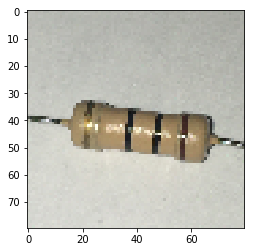

これは91%の確率で10です！！


In [30]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2

photo="IMG_9349.jpg"
labels = ["10","22","47",
              "100","220","470",
              "1k","2.2k","4.7k",
              "10k","22k","47k",
              "100k","220k","470k",
              "1M","2.2M"]

def get_model(in_shape,nb_classes):
    model=def_model(in_shape,nb_classes)
    model.compile(
        loss="categorical_crossentropy",
        optimizer=RMSprop(),
        metrics=["accuracy"])
    return model

model= get_model((photo_size,photo_size,3),17)#画像のshape、ラベルデータの数
model.load_weights("./resistors-model_RMSprop.hdf5")

img=cv2.imread(photo)
img=cv2.resize(img, (photo_size,photo_size))#画像のshape
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()
    #arrayに変換
x=np.asarray(img)
x=x.reshape(-1,photo_size,photo_size,3)#画像のshape
x=x/255
    #予測する！！
pre=model.predict([x])[0]
idx=pre.argmax()
per=int(pre[idx]*100)
print("これは"+str(per)+"%の確率で"+labels[idx]+"Ωです！！")